In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

## Shelter Animal Outcomes ##

* Get the data
* Apply **pre-processing** steps if necessary
    * data-related (e.g. filtering,  scaling, imputing, encoding, etc.)
    * model-related (e.g. scoring, dimensionality reduction, feature extraction, etc.)
* Data Analizis and Visualization 
* Choose a **model**
    * Apply the **_fit()_** method to "create" the model
    * Apply the **_predict()_** and/or **_transform()_** methods to "use" the model
    * Apply the **_score()_** method to "estimate" the result


*** Get the data ***

In [6]:
# i will work with both files at the same time in order to transform
# the data at once. in the ML part i'll splite the data in:
# Train, validation file and test

# train_df =  pd.read_csv("../input/train.csv", parse_dates=['DateTime'])
# test_df =  pd.read_csv('../input/test.csv', parse_dates=['DateTime'])
# test_df['OutcomeType'] = ''

train_df =  pd.read_csv("train.csv", parse_dates=['DateTime'])
test_df =  pd.read_csv('test.csv', parse_dates=['DateTime'])
test_df['OutcomeType'] = ''

train_df = train_df.drop(['AnimalID','OutcomeSubtype'] , axis=1)
test_df = test_df.drop('ID', axis=1)

full_data = pd.concat([train_df, test_df], axis=0)
full_data.info()
del train_df , test_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38185 entries, 0 to 11455
Data columns (total 8 columns):
AgeuponOutcome    38161 non-null object
AnimalType        38185 non-null object
Breed             38185 non-null object
Color             38185 non-null object
DateTime          38185 non-null datetime64[ns]
Name              27269 non-null object
OutcomeType       38185 non-null object
SexuponOutcome    38184 non-null object
dtypes: datetime64[ns](1), object(7)
memory usage: 2.6+ MB


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  app.launch_new_instance()


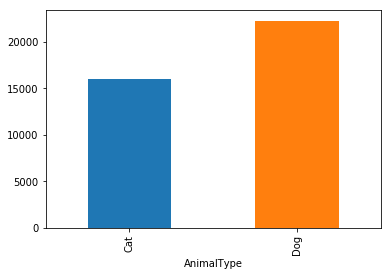

In [7]:
#check population of cat and dog balance
bal_population = full_data.groupby('AnimalType')['DateTime'].count()
bal_population.plot.bar()

*** Preprocess the data ***

In [8]:
# Check Missing Data:
def num_missing(x):
    
    return sum(x.isnull())

#Applying per column:

print ('Missing data per column\n', full_data.apply(num_missing, axis=0)) #axis=0 defines that function is to be applied on each column)

#Applying per row:
# "'if are there rows with a lot of missing data they should be pulled out of the calculation (althogu in this case the most important columns haven't empty data )'"

# print ('Missing data per row',df_shelter.apply(num_missing, axis=1).sort_values(ascending=False)) #axis=1 defines that function is to be applied on each row)

Missing data per column
 AgeuponOutcome       24
AnimalType            0
Breed                 0
Color                 0
DateTime              0
Name              10916
OutcomeType           0
SexuponOutcome        1
dtype: int64


In [9]:
#clean empty rows (rows without Datatime, AnimalType and Age aren't usefull)
mask = ~full_data['DateTime'].isna() & ~full_data['AnimalType'].isna()& ~full_data['AgeuponOutcome'].isna()
#full_data.loc[mask == False]
# print(full_data.shape)
full_data = full_data.loc[mask, :]
# print(full_data.shape)

In [10]:
# #another way to check rows with empty values 
# def count_missing(vec):
#     """counts the number of missing values in a vector
#     """
#     null_vec = pd.isnull(vec) # vector of True/False
#     null_count = np.sum(null_vec) # True has a value of 1
#     return null_count

# df_shelter.apply(count_missing, axis=1).value_counts()

*** Data preparation ***

* Data Standartization 
    * Age 

In [11]:
#step 1
full_data['AgeuponOutcome'].unique() # how do i sorted values here?.sort()

array(['1 year', '2 years', '3 weeks', '1 month', '5 months', '4 years',
       '3 months', '2 weeks', '2 months', '10 months', '6 months',
       '5 years', '7 years', '3 years', '4 months', '12 years', '9 years',
       '6 years', '1 weeks', '11 years', '4 weeks', '7 months', '8 years',
       '11 months', '4 days', '9 months', '8 months', '15 years',
       '10 years', '1 week', '0 years', '14 years', '3 days', '6 days',
       '5 days', '5 weeks', '2 days', '16 years', '1 day', '13 years',
       '17 years', '18 years', '19 years', '20 years', '22 years'],
      dtype=object)

In [12]:
# step 2 & 3
# Calculating the total animal's age:
full_data['AgeuponOutcome_Time']= full_data['AgeuponOutcome'].str.split(' ').str.get(1) #split the data 
full_data['AgeuponOutcome_Time']=full_data['AgeuponOutcome_Time'].replace( ['year', 'years', 'week', 'weeks', 'month','months', 'days','day'], 
                                                                [365, 365, 7, 7,30.5, 30.5, 1,1]) #replace by the total days 
#fill the empty values in order to be able to do math calculations
full_data['AgeuponOutcome_Time'] = full_data['AgeuponOutcome_Time'].fillna(0).astype(float)

#transform the age data to numbers that we can manipulate with math tecniques
full_data['AgeuponOutcome_Age']= full_data['AgeuponOutcome'].str.split(' ').str.get(0).fillna(0).astype(float)

#calculate the age in days 
full_data['AgeuponOutcome_InDays']= full_data['AgeuponOutcome_Age']* full_data['AgeuponOutcome_Time']

#calculate the age in years
full_data['AgeuponOutcome_InYears']= full_data['AgeuponOutcome_InDays']/365



In [13]:
#split the gender of  the animal 
def General_gender(x):
    if x == 'Female':
        return 'Female'
    elif x == 'Male':
        return 'Male'
    else:
        return 'unknow'
    
full_data['Gender']= full_data['SexuponOutcome'].str.split(' ').str.get(1) #separate general gender
full_data['Gender'] = full_data.Gender.apply(General_gender) 

# data.loc[data.Gender == 'unknow'].count()
# data.loc[data.Gender.isnull()].count()


*** Data analizis***

Dogs vs cats -- Segmentation Age's 

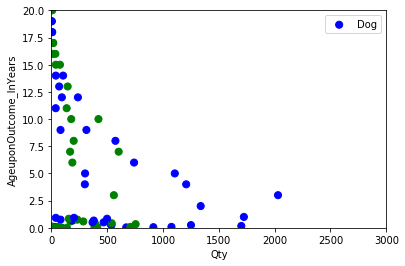

In [14]:
from numpy import where  #why do i need to import "where "again?

Ages = full_data.groupby(['AnimalType','AgeuponOutcome_InYears'])['AgeuponOutcome_InYears'].count().reset_index(name='Qty')
a_min, a_max = 0, 3000
y_min, y_max = 0, 20
Ages.plot('Qty', 'AgeuponOutcome_InYears', kind='scatter',
          xlim=[a_min, a_max], ylim=[y_min, y_max],
          c=where(full_data.AnimalType =='Dog', 'blue', 'green'),legend = True, 
          label = 'Dog' , s=50)

The scattered distribution of animals in ages does not tell us much, except that in both cases the most common age of and specific outcome reason in the shelters is around the first two years of life.

In order to be able to study more deep the data, 
I will create groups of ages based on the following links:
for cat category :
https://www.google.co.il/search?q=stages+of+age+dogs&source=lnms&tbm=isch&sa=X&ved=0ahUKEwiA3IuE0NXbAhWHK8AKHXbNDf0Q_AUICigB&biw=1366&bih=635#imgrc=eQu8yLrz9XWLRM:
for dog's category : 
https://www.google.co.il/search?q=stages+of+age+dogs&source=lnms&tbm=isch&sa=X&ved=0ahUKEwiA3IuE0NXbAhWHK8AKHXbNDf0Q_AUICigB&biw=1366&bih=635#imgrc=womRL2LDYl5SOM:'''
More or less they have the same stages :

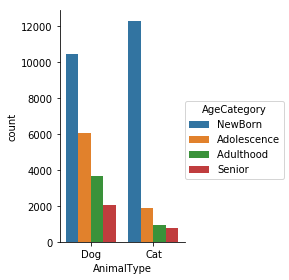

In [15]:
def CategoryAge(x):
    if x <= 1.5:
        return 'NewBorn'
    elif 1.5 < x <= 3 :
        return 'Adolescence'
    elif 3 < x <= 7 :
        return 'Adulthood '
    else:
        return 'Senior'
    
full_data['AgeCategory'] = full_data.AgeuponOutcome_InYears.apply(CategoryAge)
sns.factorplot(x="AnimalType", hue="AgeCategory", data=full_data, kind="count",
                    size=4, aspect=.7)


In [16]:
#Drill down into each Animaltype and current OutcomeType

dogs = full_data.loc[(full_data['AnimalType']=='Dog' )]
cats = full_data.loc[(full_data['AnimalType']=='Cat')]

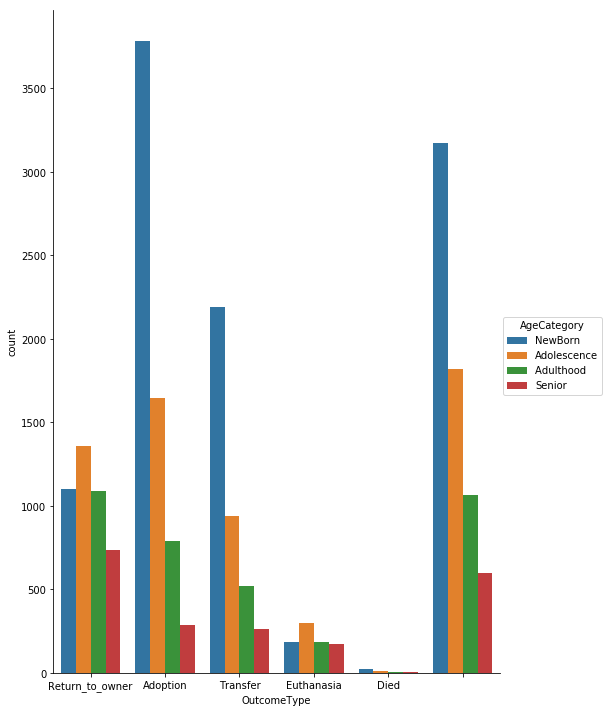

In [17]:
#Check the segmentation of the cases based on all dog's data, 
#AgeCategory and OutcomeType

sns.factorplot(x="OutcomeType", hue="AgeCategory", data=dogs, kind="count",
                    size=10, aspect=.7)


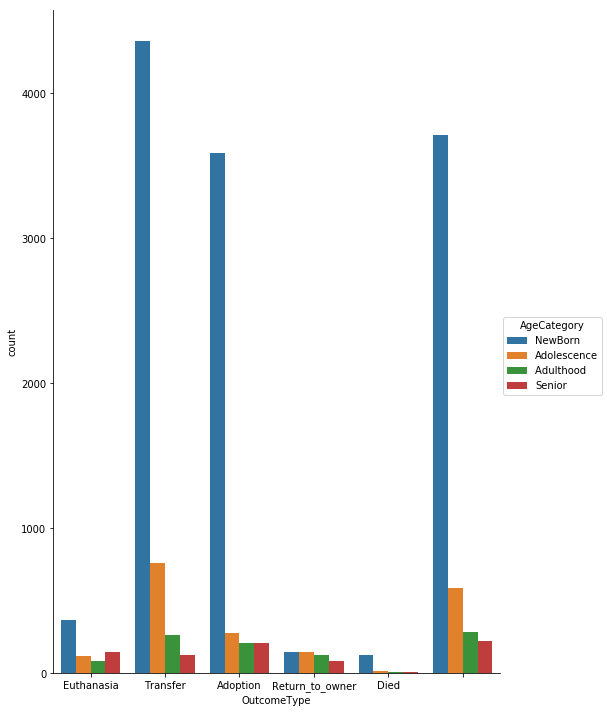

In [18]:
#Check the segmentation of the cases based on all cat's data, 
#AgeCategory and OutcomeType

sns.factorplot(x="OutcomeType", hue="AgeCategory", data=cats, kind="count",
                    size=10, aspect=.7)

Conclusions: 

* The most common age for those animals in the shelters are during their first two years of live. 

* More dogs are outcoming to shelters due to 'return_to_owner' than cats, and it happend the most during the 'Adolescence' period, although that aren't a big differentces between the rest of the age's categories.

*** Dates and Time Analizis***

In [19]:
full_data['Day_ofWeek'] = full_data['DateTime'].dt.weekday_name
 
def WeekEnd(x):
    if x in ('Saturday', 'Sunday'):
        return 'Weekend'
    else:
        return 'NoWeekend'
    
full_data['WeekEnd'] = full_data.Day_ofWeek.apply(WeekEnd)


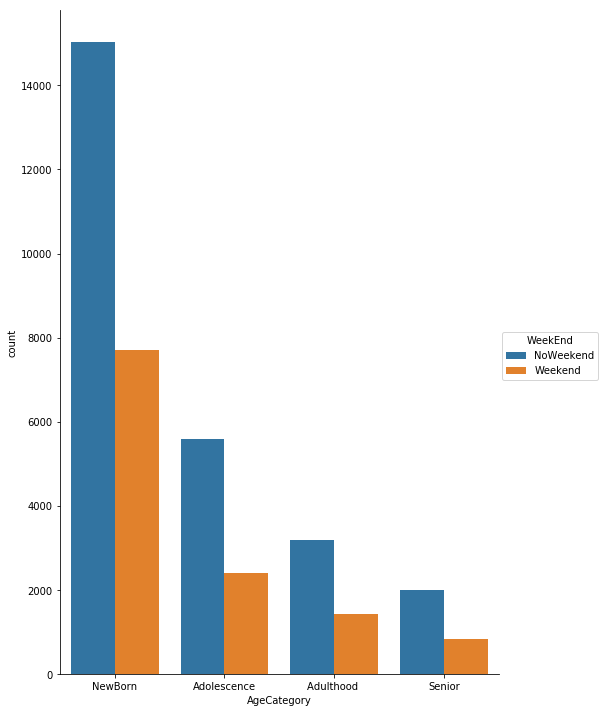

In [20]:
sns.factorplot(x="AgeCategory", hue="WeekEnd", data=full_data, kind="count",
                    size=10, aspect=.7)

**Conclusion:** 
Animal are outcoming dirug the week and not during the weekends.  

***Seasonality - *** stablish a rule for those animals that are beeing returned . 

**Are the season a parameter to take into account?**

In [21]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
dr = full_data.DateTime
holidays = cal.holidays(start=dr.min(), end=dr.max())
full_data['Holiday'] = full_data['DateTime'].isin(holidays)


In [22]:
# Check status
full_data.groupby(['Holiday'])['DateTime'].count()

Holiday
False    38138
True        23
Name: DateTime, dtype: int64

***Conclusion:*** Most of the pet's are going outthe shelters during non holidays period

***Analizis by gender***

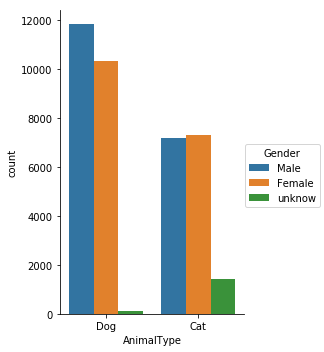

In [23]:
sns.factorplot(x="AnimalType", hue="Gender", data=full_data, kind="count",
                    size=5, aspect=.7)

In [24]:
full_data['Name_missing'] = full_data['Name'].isna()
full_data.groupby(['AnimalType'])['Name_missing'].count()
full_data = full_data[full_data['Name_missing']==True]
# sns.factorplot(x="OutcomeType", hue="AnimalType", data=name_missing, kind="count",
#                     size=4, aspect=4)

***Conclusion: ***  no conclusion from the last two analizis 

***Spliting the color and finding more metrics ***

In [25]:
#color
           
full_data['Color1'] = full_data.Color.str.split('/').str.get(1)  
full_data['Color2'] =full_data.Color.str.split('/').str.get(2)  
full_data['unicolor'] = full_data.Color1.apply(lambda x: 1 if x else 0) 

# full_data['unicolor'].isna()      

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [26]:
#checking if the breed is mix or not
def get_mix(x):
    x = str(x)
    if x.find('Mix') >= 0: return 'mix'
    return 'not'
full_data['Mix'] = full_data.Breed.apply(get_mix)


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Machine Lerning
***Decision Tree (Outcome)***
Start Point

In [27]:
# full_data.columns

In [28]:
from sklearn.model_selection import train_test_split

#splite the files test and train again

X_test_general =  full_data[full_data['OutcomeType']==''] 
X_train_general = full_data[full_data['OutcomeType']!='']

#create the Target for train
X_train = X_train_general.drop('OutcomeType', axis = 1)
X_Target = X_test_general.drop('OutcomeType', axis = 1)
y_train = X_train_general.OutcomeType

#create file for the frist cheking
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,train_size=0.7, random_state=451816)



C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [29]:
# Choose relevant features for start the prediction 

X_train = X_train[['AnimalType','SexuponOutcome',
                      'AgeuponOutcome_InYears', 'Gender',
                      'AgeCategory','Day_ofWeek','WeekEnd',
                      'Holiday','Name_missing','unicolor']]
X_test = X_test[['AnimalType','SexuponOutcome',
                      'AgeuponOutcome_InYears', 'Gender',
                      'AgeCategory','Day_ofWeek','WeekEnd',
                      'Holiday','Name_missing','unicolor']]

X_train_dm= pd.get_dummies(X_train)
X_test_dm= pd.get_dummies(X_test)

# X_train.head(2)
# X_test.head(2)
# X_train_dm.head(2)
# y_train.head(2)

***Fit the model***

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

#fit the model (X_train_dm,y_train )
shelter_dt = DecisionTreeClassifier(max_depth=5).fit(X_train_dm, y_train)
# Assess the model
cm = confusion_matrix(y_true=y_train,
                      y_pred=shelter_dt.predict(X_train_dm))
pd.DataFrame(cm,
             index=shelter_dt.classes_,
             columns=shelter_dt.classes_)

,Adoption,Died,Euthanasia,Return_to_owner,Transfer
Adoption,1118,0,4,0,44
Died,2,0,10,0,73
Euthanasia,7,0,200,0,365
Return_to_owner,46,0,10,1,55
Transfer,317,0,116,0,3003


In [31]:
#Accuracy
print('Accuracy Validation', accuracy_score(y_true=y_train,
                      y_pred=shelter_dt.predict(X_train_dm)))

Accuracy Validation 0.8046918637125302


In [32]:
#improve the accuraccy by max_dep
shelter_dt_3 = DecisionTreeClassifier(max_depth=3).fit(X_train_dm, y_train)
shelter_dt_5 = DecisionTreeClassifier(max_depth=5).fit(X_train_dm, y_train)
shelter_dt_20 = DecisionTreeClassifier(max_depth=20).fit(X_train_dm, y_train)
acc_3 = accuracy_score(y_true=y_train,
                      y_pred=shelter_dt_3.predict(X_train_dm))
acc_4 = accuracy_score(y_true=y_train,
                      y_pred=shelter_dt.predict(X_train_dm))
acc_5 = accuracy_score(y_true=y_train,
                      y_pred=shelter_dt_5.predict(X_train_dm))
acc_20 = accuracy_score(y_true=y_train,
                      y_pred=shelter_dt_20.predict(X_train_dm))
Max_dep_t = ['max_dep3', 'max_dep4','max_dep5', 'max_dep20']
Max_dep_r = [acc_3, acc_4, acc_5, acc_20]
best_accurracy = dict(zip(Max_dep_t,Max_dep_r))
best_accurracy

{'max_dep20': 0.8532861664494508,
 'max_dep3': 0.7788121392664308,
 'max_dep4': 0.8046918637125302,
 'max_dep5': 0.8046918637125302}

In [33]:
#fit the model (X_train_dm,y_train )
# shelter_dt = DecisionTreeClassifier(max_depth=5).fit(X_train_dm, y_train)
# Assess the model
cm = confusion_matrix(y_true=y_train,
                      y_pred=shelter_dt_20.predict(X_train_dm))
pd.DataFrame(cm,
             index=shelter_dt_20.classes_,
             columns=shelter_dt_20.classes_)

,Adoption,Died,Euthanasia,Return_to_owner,Transfer
Adoption,1105,0,1,0,60
Died,1,26,5,0,53
Euthanasia,8,5,311,1,247
Return_to_owner,35,0,10,37,30
Transfer,218,10,98,6,3104


In [34]:
#validating the model with the validation file from train
clf = DecisionTreeClassifier(max_depth=20)

clf.fit(X_train_dm, y_train)
print(clf.score(X_train_dm, y_train))
print(clf.score(X_test_dm, y_test))


0.8532861664494508
0.7662901824500434


***Adding features to the analizis in order to obtein better prediction for the animal type***

In [35]:
# DateTime (during the day)
interval = pd.to_datetime(full_data['DateTime'])-pd.to_datetime('2013-01-01')
full_data.loc[:, 'DateTime_day'] = interval /np.timedelta64(1, 'D')
interval = ((interval/np.timedelta64(1, 'D'))%1*24)
interval[(interval>=0) & (interval)<6] = 0 #'midnight'
interval[(interval>=6) & (interval<12)] = 1 #'morning'
interval[(interval>=12) & (interval<18)] = 2 #'afternoon'
interval[(interval>=18) & (interval<22)] = 3 #'evening'
interval[(interval>=22) & (interval<24)] =0 # 'midnight'
full_data.loc[:, 'DateTime_intday'] = interval

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [36]:
# SexuponOutcome - increace the feature definition
full_data.loc[:,['SexuponOutcome']] = full_data['SexuponOutcome'].fillna(full_data['SexuponOutcome'].mode()[0])
full_data['Sex'] = full_data['SexuponOutcome'].map({'Intact Female':0,'Spayed Female':0,'Intact Male':1,'Neutered Male':1,'Unknown':2})
full_data['IsIntact'] = full_data['SexuponOutcome'].map({'Intact Female':0,'Intact Male':0, 'Neutered Male':1,'Spayed Female':1,'Unknown':2})
full_data[['SexuponOutcome','Sex','IsIntact']].head()

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

,SexuponOutcome,Sex,IsIntact
3,Intact Male,1,0
4,Neutered Male,1,1
7,Unknown,2,2
9,Spayed Female,0,1
10,Unknown,2,2


In [37]:
#splite the files test and train again

X_test_general_1 =  full_data[full_data['OutcomeType']==''] 
X_train_general_1 = full_data[full_data['OutcomeType']!='']

#create the Target for train
X_train_1 = X_train_general_1.drop('OutcomeType', axis = 1)
X_Target_1 = X_test_general_1.drop('OutcomeType', axis = 1)
y_train_1 = X_train_general_1.OutcomeType


#create file for the frist cheking
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_train_1,y_train_1,train_size=0.7, random_state=451816)


C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [38]:
# Choose relevant features for start the prediction 

X_train_1 = X_train_1[['DateTime_intday','AnimalType',
                       'SexuponOutcome','Sex','IsIntact',
                      'AgeuponOutcome_InYears', 'Gender',
                      'AgeCategory','Day_ofWeek','WeekEnd',
                      'Holiday','Name_missing','unicolor']]
X_test_1 = X_test_1[['DateTime_intday','AnimalType',
                       'SexuponOutcome','Sex','IsIntact',
                      'AgeuponOutcome_InYears', 'Gender',
                      'AgeCategory','Day_ofWeek','WeekEnd',
                      'Holiday','Name_missing','unicolor']]

X_train_dm_1= pd.get_dummies(X_train_1)
X_test_dm_1= pd.get_dummies(X_test_1)

# X_train.head(2)
# X_test.head(2)
# X_train_dm.head(2)
# y_train.head(2)

In [39]:
#fit the model (X_train_dm,y_train )
shelter_dt_1 = DecisionTreeClassifier(max_depth=5).fit(X_train_dm_1, y_train_1)
# Assess the model
cm = confusion_matrix(y_true=y_train_1,
                      y_pred=shelter_dt_1.predict(X_train_dm_1))
#Accuracy
print('Accuracy with more features',accuracy_score(y_true=y_train,
                      y_pred=shelter_dt_1.predict(X_train_dm_1)))


Accuracy with more features 0.8061813442561907


In [40]:
# Try to keep improving the data
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

steps = [ ('scale', StandardScaler()), ('reduce_dim', PCA(2)), ('clf', RandomForestClassifier()) ]
pipe = Pipeline(steps)

pipe.fit(X_train_dm_1, y_train_1)
train_pred = pipe.predict(X_train_dm_1)
print('Accuracy with Pipeline Steps', accuracy_score(train_pred, y_train_1))


Accuracy with Pipeline Steps 0.8430459877117855


In [41]:
#Validating the model :

# pipe.fit(X_train_dm_1, y_train_1)
train_pred = pipe.predict(X_test_dm_1)
accuracy_score(train_pred, y_test_1)



0.7602085143353605

In [42]:
# classifiers 

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

clf1 = LogisticRegression()
clf2 = RandomForestClassifier()
clf3 = SVC()

classifiers = [('LR', clf1), ('DT', clf2), ('SVM', clf3)]

results = y_train_1.to_frame()
for clf_name, clf in classifiers:
    clf.fit(X_train_dm_1, y_train_1)
    results[clf_name] = clf.predict(X_train_dm_1)
    print("{:3} classifier:\n \
        \ttrain accuracy: {:.2f}\n \
        \ttest accuracy: {:.2f}"\
        .format(clf_name, 
                clf.score(X_train_dm_1, y_train_1), 
                clf.score(X_test_dm_1, y_test_1)))

  

LR  classifier:
         	train accuracy: 0.79
         	test accuracy: 0.79
DT  classifier:
         	train accuracy: 0.85
         	test accuracy: 0.77
SVM classifier:
         	train accuracy: 0.80
         	test accuracy: 0.80


In [43]:
#checking for overfit
from sklearn.model_selection import cross_val_score

for n in range (1,5):
    pipe.set_params(reduce_dim__n_components = n)
    scores = cross_val_score(pipe,X_train_dm_1, y_train_1,cv=5)
    print(f'{n} components')
    print(f'mean: {scores.mean()}')
    print(f'std: {scores.std()}\n')

1 components
mean: 0.7495836445774458
std: 0.008699840698048678

2 components
mean: 0.7674566143164785
std: 0.0069091081178369665

3 components
mean: 0.7590886633126661
std: 0.009195212297965258

4 components
mean: 0.7702459351815735
std: 0.004338308448955257



# Conclussion : 

RandomForestClassifier will give us the best accuracy in order to predic what will be the OutcomeType:
    
            train accuracy: 0.85
         	test accuracy: 0.77

In [86]:
#upload resoults
# X_Target_1.head(2)

X_target_1_upload = X_Target_1[['DateTime_intday','AnimalType',
                       'SexuponOutcome','Sex','IsIntact',
                      'AgeuponOutcome_InYears', 'Gender',
                      'AgeCategory','Day_ofWeek','WeekEnd',
                      'Holiday','Name_missing','unicolor']]


In [88]:
# Target prediction 
X_target_1_upload = pd.get_dummies(X_target_1_upload)
probability = pipe.predict_proba(X_target_1_upload)

#file preparation
columns = pipe.classes_
results = pd.DataFrame(data = X_target_1_upload, columns = columns )
#each result has their corresponding probabilistic value
results["Adoption"] = probability[:,0]
results["Died"] = probability[:,1]
results["Euthanasia"] = probability[:,2]
results["Return_to_owner"] = probability[:,3]
results["Transfer"] = probability[:,4]
results.head(2)

,Adoption,Died,Euthanasia,Return_to_owner,Transfer
13,0.457976,0.0,0.0,0.117738,0.424286
19,0.000000,0.0,0.0,0.025000,0.975000


In [96]:
results.to_csv("submition.csv", index= True, index_label='ID')

In [97]:
pd.read_csv("submition.csv")

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,13,0.457976,0.000000,0.000000,0.117738,0.424286
1,19,0.000000,0.000000,0.000000,0.025000,0.975000
2,21,0.000000,0.000000,0.234286,0.000000,0.765714
3,23,0.000000,0.000000,0.000000,0.000000,1.000000
4,25,0.212778,0.000000,0.084650,0.000000,0.702572
5,27,0.000000,0.000000,0.010526,0.000000,0.989474
6,30,0.000000,0.000000,0.000000,0.000000,1.000000
7,32,0.000000,0.109329,0.000000,0.000000,0.890671
8,36,0.010000,0.000000,0.010000,0.063333,0.916667
9,39,0.568200,0.000000,0.000000,0.000000,0.431800
